# Projections Evaluation

We will evaluate the different projection methods used in MoReVis.

The considered projection methods are PCA, MDS, force-directed layout, t-SNE, UMAp, Hilbert and Morton.

**Details:**

- PCA, MDS, force-directed layout, t-SNE, UMAp, Hilbert and Morton projections applied to all data.
- Use PCA as the start position for t-SNE and UMAp.
- MDS, force-directed layout, t-SNE, UMAp use distance between polygons or between centroids.

**Metrics:**

- Compute the metric 'stress measure' that considers the difference between distances of the regions and distance between rectangles, considering extent on both cases.
- Compute the metric 'crossings' that count the number of crossings of curves between timesteps.
- Compute the metric 'jump distance' that count for each object the jump in the relative ordering of curvesbetween timesteps.
- Compute the metric 'spurious intersections' that count spurious intersections between rects.
- Compute the metric 'intersection area ratio' that compute the mean ratio between intersections in 1D and 2D.

In [1]:
import pandas as pd
import numpy as np
from time import time
from ast import literal_eval
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_hex
from matplotlib import ticker
plt.style.use("seaborn-paper")
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Roboto'

# to ignore warnings from t-sne
import warnings
warnings.filterwarnings("ignore")

import sys
import os
module_path = os.path.abspath(os.path.join('../scripts'))
sys.path.append(module_path)

from metrics import compute_metrics
from morevis import MoReVis
from datasets import load_dataset

## Helper functions

In [2]:
def run_tests(df, path, projections):
    """
    Experiment handler that will iterate over the projections (and params), 
    compute the MoReVis result for each and save results.

    Inputs:
        df - DataFrame with the data to apply MoReVis
        path - path to save the results
        projections - list of tuples with projection name and dictionary of params
    
    """
    results = {
        "projection" : [],
        "params" : [],
        "spurious_intersections" : [],
        "intersection_area_ratio_mean" : [],
        "crossings_mean" : [],
        "jump_distance_mean" : [],
        "stress_measure" : [],
        'time': []
    }
    metrics = [
        "spurious_intersections", "intersection_area_ratio_mean", 
        "crossings_mean", "jump_distance_mean", "stress_measure"
    ]
    
    for (name, param) in tqdm(projections):
        
        start = time()
        morevis_result, area_scaler = MoReVis(
            df, 
            projection_name = name, 
            projection_params = param,
            plot = False,
            return_area_scaler = True
        )
        end = time()
        morevis_result = compute_metrics(morevis_result, area_scaler)
        results["projection"].append(name)
        results["params"].append(" ".join([str(k) + "=" + str(v) for (k, v) in param.items()]))
        results["time"].append(end - start)
        
        for m in metrics:
            results[m].append(morevis_result[m])

        pd.DataFrame(results).to_csv(path, index = False)

In [3]:
def parallel_coordinates(
    df,
    columns,
    columns_ranges = None,
    columns_tick_format = None,
    columns_names = None,
    color_column = None,
    color_mapper = None,
    name_mapper = None,
    legend_order = None,
    title = None
):
    """
    Simple parallel coordinates to plot the projection results.
    """
    norm_df = df.copy() # dataframe will be normalized

    fig, axes = plt.subplots(1, len(columns)-1, sharey=False, figsize=(15,5))

    if columns_ranges is None:
        columns_ranges = [None for _ in columns]

    if columns_tick_format is None:
        columns_tick_format = [None for _ in columns]

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for i, col in enumerate(columns):
        if columns_ranges[i] is None:
            col_max = df[col].max()
            col_min = df[col].min()
        else:
            col_max = columns_ranges[i][1]
            col_min = columns_ranges[i][0]

        min_max_range[col] = [col_min, col_max]
        col_range = col_max - col_min
        if col_range == 0:
            col_range = 1
        norm_df[col] = (df[col] - col_min) / col_range

    x = list(range(len(columns)))
    axx = axes[-1].twinx()
    # Plot each row
    if color_column is None:
        for i, ax in enumerate(axes):
            for idx in norm_df.index:
                ax.plot(x, norm_df.loc[idx, columns], c = "blue", lw = 3)
        for idx in norm_df.index:
            axx.plot(x, norm_df.loc[idx, columns], c = "blue", lw = 3)
    else:
        color_values = norm_df[color_column].unique()
        colormap = plt.get_cmap("Paired")
        if color_column is not None and color_mapper is None:
            color_mapper = {color_value: colormap(i) for i, color_value in enumerate(color_values)}

        for ii, value in enumerate(color_values):
            df_value = norm_df[norm_df[color_column] == value]
            for i, ax in enumerate(axes[:-1]):
                for idx in df_value.index:
                    ax.plot(x, df_value.loc[idx, columns], alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
            for idx in df_value.index:
                axx.plot(x, df_value.loc[idx, columns], alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
    
    for i, ax in enumerate(axes):
        ax.set_xlim([x[i], x[i+1]])
        ax.set_ylim([-0.05, 1.05])
        # get yticks from ax
        yticks = ax.get_yticks()
        col_min = min_max_range[columns[i]][0]
        col_max = min_max_range[columns[i]][1]
        col_range = col_max - col_min
        format_ = columns_tick_format[i]
        if format_ is None:
            ax.set_yticklabels([np.round(yi * col_range  + col_min, 1)  for yi in yticks], fontsize = 18)
        else:
            ax.set_yticklabels([format_(yi * col_range  + col_min)  for yi in yticks], fontsize = 18)
        #ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    
    axes[0].set_ylim([-0.05, 1.05])

    for i, ax in enumerate(axes[:-1]):
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.set_xticklabels([columns_names[i]], fontsize = 18)

    axes[-1].xaxis.set_major_locator(ticker.FixedLocator([i+1, i+2]))
    axes[-1].set_xticklabels([columns_names[i+1], columns_names[i+2]], fontsize = 18)

    # tick for right side of last axis
    yticks = axes[-1].get_yticks()
    col_min = min_max_range[columns[len(axes)]][0]
    col_max = min_max_range[columns[len(axes)]][1]
    col_range = col_max - col_min
    format_ = columns_tick_format[len(axes)]
    if format_ is None:
        axx.set_yticklabels([np.round((yi * col_range +  col_min), 1)  for yi in yticks], fontsize = 18)
    else:
        axx.set_yticklabels([format_(yi * col_range +  col_min)  for yi in yticks], fontsize = 18)
    axx.set_axisbelow(True)
    axx.set_ylim([-0.05, 1.05])
    axx.spines['top'].set_visible(False)
    axx.spines['bottom'].set_visible(False)

    
    if title:
        plt.suptitle(title, y = 1, fontsize = 20)
    # Remove space between subplots
    plt.subplots_adjust(wspace=0)
    handles = [
        mpatches.Patch(color=to_hex(color_mapper[value]), label=name_mapper[value]) for value in legend_order
    ]
    plt.legend(handles = handles, bbox_to_anchor=(1.3, 1), ncol = len(legend_order))

In [4]:
def read_dicts(x):
    """Helper function to read dictionary from strings saved."""
    if x == "{}":
        return {}
    else:
        d = {}
        for y in x.split(" "):
            k, v = y.split("=")
            d[k] = literal_eval(v)
        return d

## Listing projections parameters


The function above will create the list with all the projections and with dicts with the values considered for each parameter. The parameters and values were selected based on the literature of these projection methods. These parameters are:

- PCA: none.
- MDS: if is applied the metric version or not and if it considers the distance between centroids or polygons.
- force-directed layout: 
  - number of iterations of the simulation in $\{2, 4, 6, 8\}$;
  - fraction value of the jumps in the values in $\{0.05, 0.1, 0.15, 0.25\}$.
- t-SNE:
  - perplexity in $\{15, 30, 45, 60\}$;
  - learning rate in $\{100, 250, 500\}$;
  - number of iterations in $\{500, 1000, 1500\}$.
- UMAP:
  - number of neighbors in $\{5, 10, 15, 20\}$;
  - min distance between points in the new space in $\{0.1, 0.25, 0.5, 1\}$;
  - spread of points in new space in $\{1, 1.5, 2\}$;
  - number of iterations in $\{200, 300, 500\}$.
- Hilbert:
 - curve order (degree of the discretization of space) in $\{3, 4, 5, 6, 7, 8\}$.
- Morton:
  - curve order (degree of the discretization of space) in $\{3, 4, 5, 6, 7, 8\}$.

In [5]:
def get_projections_list(polygon = True):
    projections = []
    perplexity_values = [15, 30, 45, 60]
    learning_rate_values = [100, 250, 500]
    iterations_values = [500, 1000, 1500]
    n_neighbors_values = [5, 10, 15, 20]
    min_dist_values = [0.1, 0.25, 0.5, 1]
    spread_values = [1.0, 1.5, 2]
    n_epochs_values = [200, 300, 500]
    level_values = [3, 4, 5, 6, 7, 8]
    max_iter_values = [2, 4, 6, 8]
    frac_values = [0.05, 0.1, 0.15, 0.25]

    # projections with all points
    projections.append(("pca", {}))
    projections.append(("mds", {"metric" : True}))
    projections.append(("mds", {"metric" : False}))
    for perplexity in perplexity_values:
        for learning_rate in learning_rate_values:
            for iterations in iterations_values:
                projections.append(("tsne", {"perplexity" : perplexity, "learning_rate" : learning_rate, "iterations" : iterations}))
    for n_neighbors in n_neighbors_values:
        for min_dist in min_dist_values:
            for spread in spread_values:
                for n_epoch in n_epochs_values:
                    projections.append(("umap", {"n_epochs" : n_epoch, "spread" : spread, "n_neighbors" : n_neighbors, "min_dist" : min_dist}))
    for level in level_values:
        projections.append(("hilbert", {"level" : level}))
    for level in [4, 5, 6]:
        projections.append(("morton", {"level" : level}))

    if polygon:
        # MDS, TSNE, UMAP with polygon shapes
        projections.append(("mds", {"metric" : True, "poly_distance" : True}))
        projections.append(("mds", {"metric" : False, "poly_distance" : True}))
        for perplexity in perplexity_values:
            for learning_rate in learning_rate_values:
                for iterations in iterations_values:
                    projections.append(("tsne", {"perplexity" : perplexity, "learning_rate" : learning_rate, "iterations" : iterations, "poly_distance" : True}))
        for n_neighbors in n_neighbors_values:
            for min_dist in min_dist_values:
                for spread in spread_values:
                    for n_epoch in n_epochs_values:
                        projections.append(("umap", {"n_epochs" : n_epoch, "spread" : spread, "n_neighbors" : n_neighbors, "min_dist" : min_dist, "poly_distance" : True}))
    
    for max_iter in max_iter_values:
        for frac in frac_values:
            projections.append(("force", {"max_iter" : max_iter, "frac" : frac}))

    return projections

## Running experiments

Now we run experiments with the WILDTRACK and HURDAT datasets.

In [6]:
projections = get_projections_list()
wildtrack_df = load_dataset("wildtrack_use_case")
hurdat_df = load_dataset("hurdat_use_case")

In [7]:
### LONG RUNNING TIME ###
run_tests(wildtrack_df, "metrics-results/projections_evaluation_wildtrack.csv", projections)

100%|██████████| 390/390 [3:35:49<00:00, 33.20s/it]  


In [11]:
### LONG RUNNING TIME ###
run_tests(hurdat_df, "metrics-results/projections_evaluation_hurdat.csv", projections,)

100%|██████████| 390/390 [4:40:26<00:00, 43.15s/it]  


### Visualize results

We now create parallel coordinates plots with the results of the experiments.

In [24]:
# initial configuration

color_mapper = {
    "hilbert":  "#fdb462",
    "morton": "#FBFB64",
    "mds" : "#b3de69",
    "pca" : "#8dd3c7",
    "force": "#fb8072",
    "force_2" : "#000000",
    "umap": "#26577A",
    "tsne":   "#bebada",
}

name_mapper = {
    "pca" : "PCA",
    "force" : "Force",
    "force_2" : "Force Networkx",
    "hilbert" : "Hilbert",
    "morton" : "Morton",
    "tsne" : "t-SNE",
    "umap" : "UMAP",
    "mds" : "MDS",
}

metrics = [
    "spurious_intersections", "intersection_area_ratio_mean", "crossings_mean", 
    "jump_distance_mean", "stress_measure" 
]

projections_names = ["pca", "mds", "force", "tsne", "umap", "hilbert", "morton"]

In [25]:
results = pd.read_csv("metrics-results/projections_evaluation_wildtrack.csv")
results.params = results.params.fillna("{}").apply(read_dicts)

results_best_parameters = results.sort_values(["projection", "stress_measure", "crossings_mean", "jump_distance_mean"]).drop_duplicates(
    subset = ["projection"]
)

for proj in projections_names:
    print(f"Proj: {proj}")
    params = results_best_parameters[results_best_parameters.projection == proj].params.iloc[0]
    print(f"Params:\n\t{params}")

Proj: pca
Params:
	{}
Proj: mds
Params:
	{'metric': True, 'poly_distance': True}
Proj: force
Params:
	{'max_iter': 4, 'frac': 0.1}
Proj: tsne
Params:
	{'perplexity': 45, 'learning_rate': 250, 'iterations': 1000}
Proj: umap
Params:
	{'n_epochs': 500, 'spread': 1.0, 'n_neighbors': 20, 'min_dist': 1, 'poly_distance': True}
Proj: hilbert
Params:
	{'level': 7}
Proj: morton
Params:
	{'level': 6}


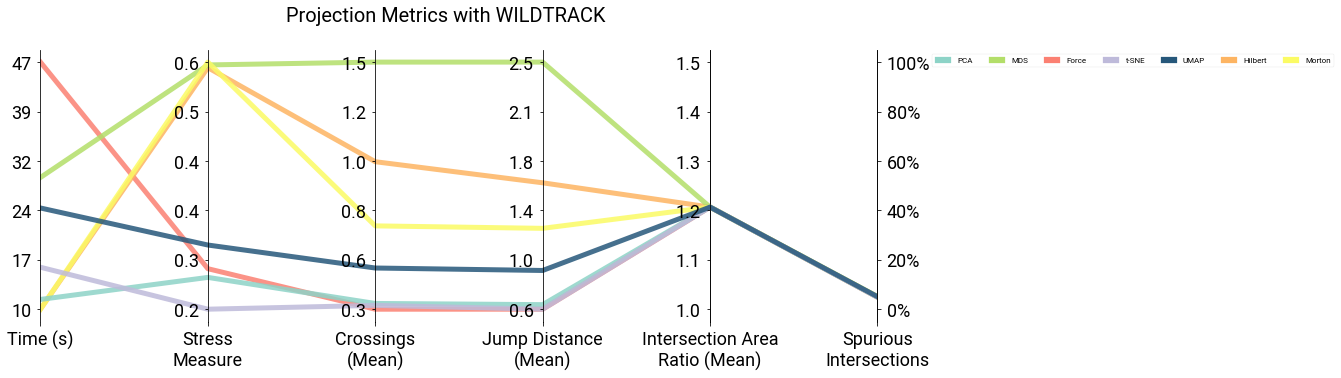

In [26]:
parallel_coordinates(
    df = results_best_parameters,
    columns = [
        'time',
        'stress_measure',
        'crossings_mean',
        'jump_distance_mean',
        'intersection_area_ratio_mean',
        'spurious_intersections',
    ],
    columns_ranges = [None, None, None, None, [1, 1.5], [0, 1]],
    columns_tick_format = [lambda x : int(x), None,  None, None, None,  lambda x : f"{int(x * 100)}%"],
    columns_names = [
        'Time (s)',
        'Stress\nMeasure',
        'Crossings\n(Mean)',
        'Jump Distance\n(Mean)',
        'Intersection Area\nRatio (Mean)',
        'Spurious\nIntersections',
    ],
    color_column = "projection",
    color_mapper = color_mapper,
    name_mapper = name_mapper,
    legend_order = projections_names,
    title = "Projection Metrics with WILDTRACK"
)

plt.savefig("plots/wildtrack_projections_metrics.svg")
plt.show()

In [27]:
results = pd.read_csv("metrics-results/projections_evaluation_hurdat.csv")
results.params = results.params.fillna("{}").apply(read_dicts)

results_best_parameters = results.sort_values(["projection", "stress_measure", "crossings_mean", "jump_distance_mean"]).drop_duplicates(
    subset = ["projection"]
)

for proj in projections_names:
    print(f"Proj: {proj}")
    params = results_best_parameters[results_best_parameters.projection == proj].params.iloc[0]
    print(f"Params:\n\t{params}")
    

Proj: pca
Params:
	{}
Proj: mds
Params:
	{'metric': True, 'poly_distance': True}
Proj: force
Params:
	{'max_iter': 2, 'frac': 0.15}
Proj: tsne
Params:
	{'perplexity': 60, 'learning_rate': 500, 'iterations': 1000}
Proj: umap
Params:
	{'n_epochs': 300, 'spread': 1.0, 'n_neighbors': 15, 'min_dist': 0.1}
Proj: hilbert
Params:
	{'level': 3}
Proj: morton
Params:
	{'level': 4}


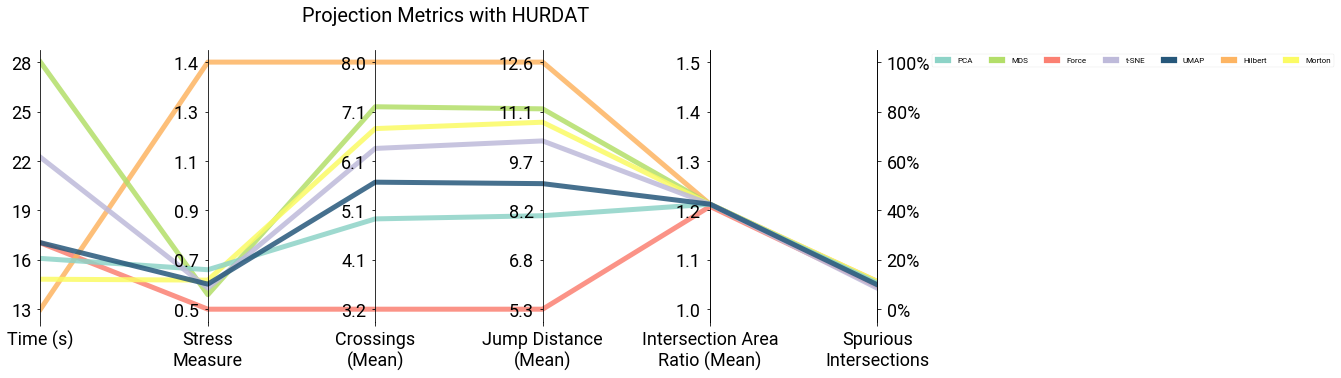

In [28]:
parallel_coordinates(
    df = results_best_parameters,
    columns = [
        'time',
        'stress_measure',
        'crossings_mean',
        'jump_distance_mean',
        'intersection_area_ratio_mean',
        'spurious_intersections',
    ],
    columns_ranges = [None, None, None, None, [1, 1.5], [0, 1]],
    columns_tick_format = [lambda x : int(x), None,  None, None, None,  lambda x : f"{int(x * 100)}%"],
    columns_names = [
        'Time (s)',
        'Stress\nMeasure',
        'Crossings\n(Mean)',
        'Jump Distance\n(Mean)',
        'Intersection Area\nRatio (Mean)',
        'Spurious\nIntersections',
    ],
    color_column = "projection",
    color_mapper = color_mapper,
    name_mapper = name_mapper,
    legend_order = projections_names,
    title = "Projection Metrics with HURDAT"
)

plt.savefig("plots/hurdat_projections_metrics.svg")
plt.show()

## Project all data X Project each timestep

Related techniques of visual summary of spatiotemporal data applied projections in each of the timesteps separately, and in our scenario, we found that it was better to apply will all the data available. In this we compare this different methods of space transformation using the motivating dataset of four objects. 

To apply t-SNE, UMAp to each timestep, we used the result of the previous timestep as the starting points for iteration.

In [8]:
projections = get_projections_list()

# add projections applied to each timestep
sigma_values = [0.4, 0.5, 0.6, 0.7]
perplexity_values = [2, 3, 4, 5]
learning_rate_values = [100, 250, 500]
iterations_values = [500, 1000, 1500]
n_neighbors_values = [2, 3, 4, 5]
min_dist_values = [0.1, 0.25, 0.5, 1]
spread_values = [1.0, 1.5, 2]
n_epochs_values = [200, 300, 500]
level_values = [3, 4, 5, 6, 7, 8]
max_iter_values = [5, 10, 15]
frac_values = [0.05, 0.1, 0.2]


# projections with points of each timestep
projections.append(("pca_timesteps", {}))
for sigma in sigma_values:
    projections.append(("spc", {"sigma" : sigma}))
projections.append(("mds_timesteps", {"metric" : True}))
projections.append(("mds_timesteps", {"metric" : False}))
for perplexity in perplexity_values:
    for learning_rate in learning_rate_values:
        for iterations in iterations_values:
            projections.append(("tsne_timesteps", {"perplexity" : perplexity, "learning_rate" : learning_rate, "iterations" : iterations}))
        
for n_neighbors in n_neighbors_values:
    for min_dist in min_dist_values:
        for spread in spread_values:
            for n_epoch in n_epochs_values:
                projections.append(("umap_timesteps", {"n_epochs" : n_epoch, "spread" : spread, "n_neighbors" : n_neighbors, "min_dist" : min_dist}))
for level in [4, 5, 6]:
    projections.append(("hilbert_timesteps", {"level" : level}))
for level in [4, 5, 6]:
    projections.append(("morton_timesteps", {"level" : level}))

projections.append(("mds_timesteps", {"metric" : True, "poly_distance" : True}))
projections.append(("mds_timesteps", {"metric" : False, "poly_distance" : True}))
for perplexity in perplexity_values:
    for learning_rate in learning_rate_values:
        for iterations in iterations_values:
            projections.append(("tsne_timesteps", {"perplexity" : perplexity, "learning_rate" : learning_rate, "iterations" : iterations, "poly_distance" : True}))
for n_neighbors in n_neighbors_values:
    for min_dist in min_dist_values:
        for spread in spread_values:
            projections.append(("umap_timesteps", {"n_neighbors" : n_neighbors, "min_dist" : min_dist, "spread" : spread, "poly_distance" : True}))

for max_iter in max_iter_values:
    for frac in frac_values:
        projections.append(("force_timesteps", {"max_iter" : max_iter, "frac" : frac}))


In [9]:
df = load_dataset("synthetic_circles")

In [11]:
#### LONG RUNNING TIME ####
run_tests(df, "metrics-results/projections_evaluation_motivating_by_timesteps.csv", projections)

100%|██████████| 678/678 [2:28:09<00:00, 13.11s/it]  


### Visualize results

In [14]:
results = pd.read_csv("metrics-results/projections_evaluation_motivating_by_timesteps.csv")
results.params = results.params.fillna("{}").apply(read_dicts)

results_best_parameters = results.sort_values(["projection", "stress_measure", "crossings_mean", "jump_distance_mean"]).drop_duplicates(
    subset = ["projection"]
)

for proj in results.projection.unique():
    print(f"Proj: {proj}")
    params = results_best_parameters[results_best_parameters.projection == proj].params.iloc[0]
    print(f"Params:\n\t{params}")
    

Proj: pca
Params:
	{}
Proj: mds
Params:
	{'metric': True}
Proj: tsne
Params:
	{'perplexity': 60, 'learning_rate': 100, 'iterations': 1000}
Proj: umap
Params:
	{'n_epochs': 200, 'spread': 1.0, 'n_neighbors': 5, 'min_dist': 0.5}
Proj: hilbert
Params:
	{'level': 3}
Proj: morton
Params:
	{'level': 6}
Proj: force
Params:
	{'max_iter': 4, 'frac': 0.05}
Proj: pca_timesteps
Params:
	{}
Proj: spc
Params:
	{'sigma': 0.4}
Proj: mds_timesteps
Params:
	{'metric': False, 'poly_distance': True}
Proj: tsne_timesteps
Params:
	{'perplexity': 5, 'learning_rate': 500, 'iterations': 1000, 'poly_distance': True}
Proj: umap_timesteps
Params:
	{'n_neighbors': 3, 'min_dist': 1, 'spread': 2, 'poly_distance': True}
Proj: hilbert_timesteps
Params:
	{'level': 5}
Proj: morton_timesteps
Params:
	{'level': 4}
Proj: force_timesteps
Params:
	{'max_iter': 10, 'frac': 0.05}


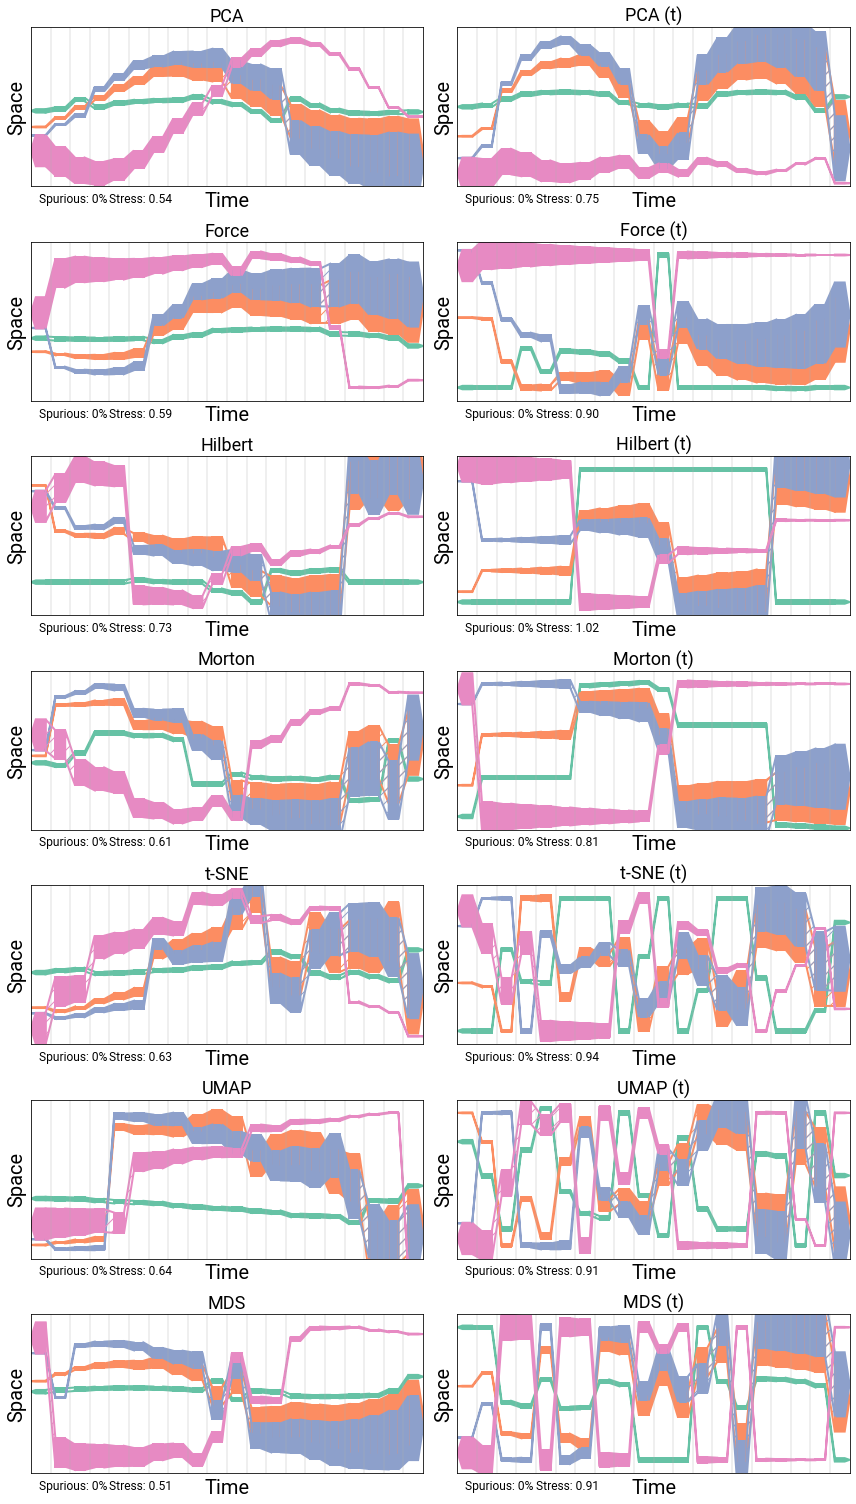

In [22]:
projections_names = ["pca","force","hilbert", "morton", "tsne", "umap", "mds"]

name_mapper = {
    "pca" : "PCA",
    "force" : "Force",
    "hilbert" : "Hilbert",
    "morton" : "Morton",
    "tsne" : "t-SNE",
    "umap" : "UMAP",
    "mds" : "MDS",
}

name_mapper_t = {
    "pca" : "SPC",
    "force" : "Force(t)",
    "hilbert" : "Hilbert(t)",
    "morton" : "Morton(t)",
    "tsne" : "SNEp",
    "umap" : "UMAP(t)",
    "mds" : "MDS(t)",
}

fig, axs = plt.subplots(nrows = len(projections_names), ncols = 2, figsize = (12, 3 * len(projections_names)))

for i, proj in enumerate(projections_names):
    temp = results[results.projection == proj]
    param = temp.iloc[0].params
    MoReVis(
        df, 
        proj, 
        projection_params = param,
        colormap_name = "Set2",
        ax = axs[i][0], 
        plot_metrics = True
    )
    
    if proj == "pca":
        proj_timesteps = "spc"
    else:
        proj_timesteps = proj + "_timesteps"
        
    temp = results[results.projection == proj_timesteps]
    param = temp.iloc[0].params
    MoReVis(
        df, 
        proj_timesteps, 
        projection_params = param,
        colormap_name = "Set2",
        ax = axs[i][1], 
        plot_metrics = True
    )

    #axs[i][0].annotate(name_mapper[proj], xy = (0.025, 1.025), xycoords = "axes fraction", fontsize = 14)
    #axs[i][1].annotate(name_mapper_t[proj], xy = (0.025, 1.025), xycoords = "axes fraction", fontsize = 14)

    #for j in range(2):
        #axs[i][j].set_xlabel("")
        #axs[i][j].set_ylabel("")
        #axs[i][j].set_xticklabels(["" for i in range( axs[i][1].get_xticks().shape[0])])
        #axs[i][j].set_yticks([])
    
    axs[i][0].set_title(f"{name_mapper[proj]}", fontsize = 18)
    axs[i][1].set_title(f"{name_mapper[proj]} (t)",  fontsize = 18)
    axs[i][0].set_ylim(-0.1, 1.1)
    axs[i][1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig("plots/projections_evaluation_motivating_by_timesteps.svg", format = "svg", dpi = fig.dpi)
plt.show()